In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using nmAPG with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each triplet of parameters $\alpha = (\beta, \gamma,m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Problem setup

In [4]:
# Total population
n = 400
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.05

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we compute the smooth transformation $p_1 = \widehat{\rho}_{\mathsf e} + 4 \big(\sin(\widehat{\rho}_{\mathsf e}) - \sin(\rho_0) \big)$.

In [5]:
T  = 3                             # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Rates for ρ̂ₑ:
βₑ, γₑ, mₑ = 0.007, 0.1, 0.05
αₑ = asarray([βₑ, γₑ, mₑ])

In [7]:
print('Basic reproduction number:', n*βₑ/(γₑ+m))

Basic reproduction number: 18.666666666666664


In [8]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [9]:
sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [10]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIR(0,ρ̂ₑ,βₑ,γₑ))

Apply smooth transformation:

In [11]:
p_1 = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

Now we split the integral $[0,T]$ into $k$ periods and compute the rolling average of $p_1$ on each subinterval yielding a vector:
\begin{align*}
    (p_2)_i = \int\limits_{t_{i}}^{t_{i+1}} \frac{p_1}{t_{i+1} - t_i} \, \mathrm{d} s  \qquad \qquad \forall i \in [0:k-1].
\end{align*}

In [12]:
from scipy.integrate import quad_vec

In [13]:
SmoothVar = lambda t: sol.sol(t) + 4 * sin(sol.sol(t) - 4 * sin(ρ̂ₑ[:,0]) )

In [14]:
num_subintervals = 50
t_values = np.linspace(0, T, num_subintervals + 1)

In [15]:
IntQUADPACK = [quad_vec(SmoothVar, t_values[i], t_values[i+1], full_output=False)   for i in range(num_subintervals)]
averages    = asarray([IntQUADPACK[i][0]    for i in range(num_subintervals)]) / ( t_values[1] - t_values[0] )
print('Maximum integration error estimate: {0:.2e}'.format(asarray([IntQUADPACK[i][1]    for i in range(num_subintervals)]).max()) )

Maximum integration error estimate: 8.97e-09


Now let's keep monotony of the function: (a) susceptibles cannot increase, (b) recovered cannot decrease, (c) infected cannot decrease until the peak is reached.

In [16]:
MonAv = averages.copy()
for i in range(1,num_subintervals):
    # Susceptible
    if MonAv[i,0] > MonAv[i-1,0]:
        MonAv[i,0] = MonAv[i-1,0]
    # Recovered
    if MonAv[i,2] < MonAv[i-1,2]:
        MonAv[i,2] = MonAv[i-1,2]
    # Infected
    idx_cut = np.digitize(Tₑ[np.argmax(ρ̂ₑ.T[:,1])], t_values) - 1    # Compute maximal increase (based on original smooth curve)
    if i <= idx_cut:
        if MonAv[i,1] < MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]
    else:
        if MonAv[i,1] > MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]

Now produce an upper semicontinuous function from the average:
\begin{align*}
    \hat{\rho} = p_3(t) = \sum_{i=0}^{k-1} (p_2)_i \iota_{ t_{i+1} \leq t < t_i  } + (p_2)_{k-1} \iota_{t=T}.
\end{align*}

In [17]:
def averaged_ρ(t):
    # Ensure t is within the defined interval
    if np.any(t < 0) or np.any(t > T):
        raise ValueError("Some t values are out of bounds!")
    
    # Find the subinterval index:
    idx = np.digitize(t, t_values) - 1
    
    # Handle the edge case where t == T
    idx = np.where(t == T, len(MonAv) - 1, idx)
    
    return MonAv[idx].T

In [18]:
averaged_ρ(asarray([0.1,0]))[0]

array([374.11785872, 380.00964371])

In [19]:
ρ̂ = averaged_ρ(Tₑ)
ρ̄ = averaged_ρ      # Functional representation

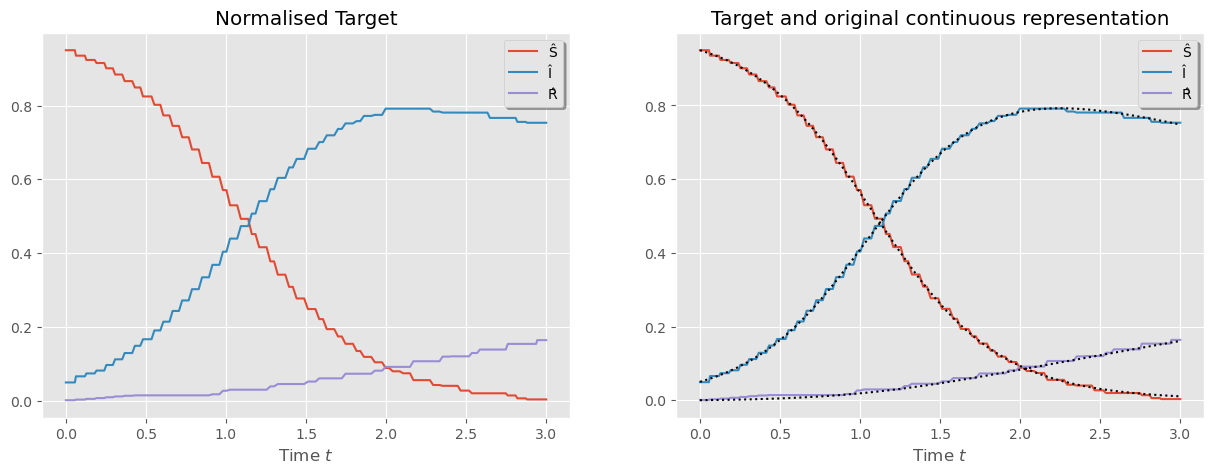

In [20]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, ρ̂.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Target and original continuous representation')
plt.show()

## Create a given state

In [21]:
# Give a random initial control
α = asarray([0.01,0.02,0.1])

In [22]:
def SIRD(t, z,  β,γ,m):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [23]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = ρ_sol.sol    # CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

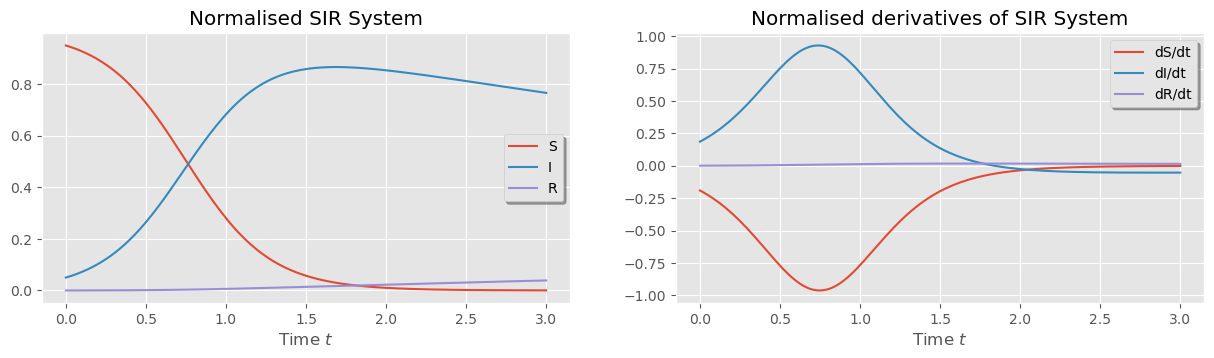

In [24]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [25]:
def Adjoint(t, z, β,γ,m, ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [26]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,0.1, ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 446 function evaluations.


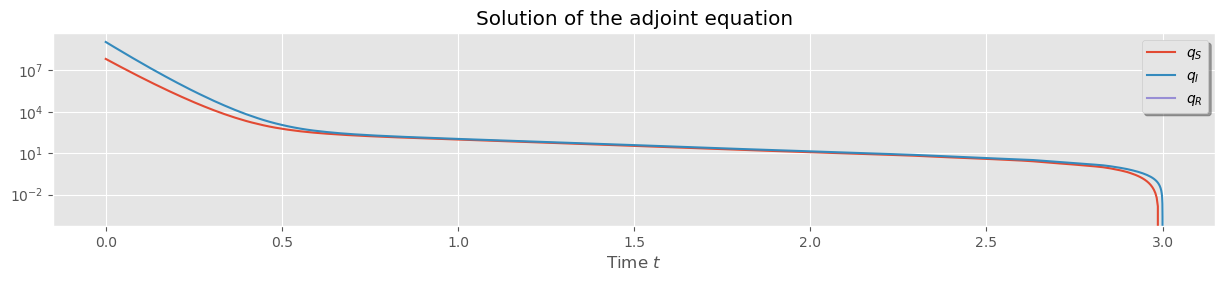

In [27]:
# Plot adjoint curves
plt.figure(figsize=(15,2.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 +m^2 ).
\end{align}

In [28]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,x=Tₑ).sum() + θ * (α**2).sum())

In [29]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [30]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+3) ))

As an example, the distance between ρ and ρ̂ is 11594.7031.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
    \\
    \frac{\partial f}{\partial m} &= \int\limits_0^T -I q_I  \, \dif t  + \theta m
\end{align}

In [31]:
q = solₛ.y[:,::-1]

In [32]:
θ = 0.1
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])  + θ * α
display(df.tolist())

[251759367575.16516, -716288666.3496727, -716259675.1077482]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [33]:
θ = 0.0

In [34]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [35]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=False, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    
    return asarray(f), df

In [36]:
obj_eval(np.asarray([0,0,0]))

(array(1.13752217), array([-119.40322227,    0.12128588,    0.14184537]))

In [37]:
# Optimal point should be around
# 0.007, 0.7, 0.3
# So we evaluate around this point

In [225]:
# Coarse evaluations (takes a long time)
nβ, nγ, nm = 41, 41, 31
Misfit = zeros([nβ, nγ, nm])
β_axis = linspace(0.001,0.15,nβ)
γ_axis = linspace(0.1,1,nγ)
m_axis = linspace(0.1,1,nm)
for (i,β) in enumerate(β_axis):
    #print(i)
    for (j,γ) in enumerate(γ_axis):
        for (k,m) in enumerate(m_axis):
            Misfit[i,j,k] = obj_eval_a( asarray([β,γ,m]) ).item()

In [244]:
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)
M_0, β_0, γ_0, m_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]],    m_axis[i_0[2]]
print('Smallest objective found in the mesh: {0:.4e} with (β,γ,m): ({1:.4f},{2:.4f},{3:.4f})'.format(M_0,β_0,γ_0, m_0))

Smallest objective found in the mesh: 7.2703e-03 with (β,γ,m): (0.0084,0.7750,0.5800)


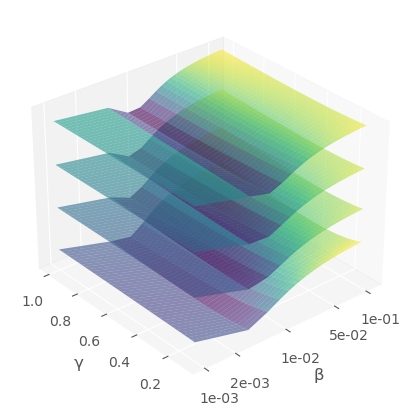

In [265]:
# Create grid of (β,γ)
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')

# Create a 3D plot
fig = plt.figure( figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces for each z value
for k in [0,10,20,30]:
    # Create a surface plot for each z value and stack them vertically
    ax.plot_surface(np.log(X_c), Y_c, Misfit[:,:,k]+k/10, cmap='viridis', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('β')
ax.set_ylabel('γ')

#ax.set_zlabel('Z (graphically scaled)')
#ax.set_title('Stacked Surface Plots for varying $m$')

ax.view_init(elev=30, azim=230)
ax.set_box_aspect((2, 2, 1.5))

# Set the ticks
ax.set_xticks([-6.9,-6,-4.5,-3,-2]);    #ax.set_yticks([-2.3,-1.5,-0.5,0])
ax.set_xticklabels([f'{val:.0e}' for val in np.exp(ax.get_xticks())])
#ax.set_yticklabels([f'{val:.0e}' for val in np.exp(ax.get_yticks())])
ax.set_zticks([])
ax.set_facecolor('xkcd:white')
plt.show()

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$. For any $L > 0$, and $\omega \in [0,1]^2$, define the the operator
$$
    p_L (\omega) := \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ].
$$

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Nonmonotone Accelerated Proximal Gradient Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \alpha_1 = \omega_1 = \nu_1 \in [0,1]^2$, $\theta_0 = 0$, $\theta_1 = 1$, $\mu \in [0,1)$, $\delta >0$, $\eta > 1$, $c_1 = j(\alpha_1)$, $\lambda_1 = 1$.</li>

    
<li>For $k \in \{1,\ldots\}$, do
<ol>
<li>Set 
    \begin{align*}
        \nu_{k} &= \alpha_k + \frac{\theta_{k-1}}{\theta_k} (\omega_k - \alpha_k) + \frac{\theta_{k-1} -1 }{\theta_k} (\alpha_k - \alpha_{k-1}) 
    \\
        s_{k} &= \nu_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\nu_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    
    
<li>Find the smallest $i_k \in \mathbb{N}$ such that
    \begin{align*}
        L &= \eta^{i_k} L_k
        \\
        \omega_{k+1} &= \mathcal{P} (\nu_k - L^{-1} \nabla j(\nu_k) ) = p_L(\nu_{k})
        \\
    j(\omega_{k+1}) &\leq \max\{c_k,j(\nu_k)\} - \delta \| \omega_{k+1} - \nu_k \|^2
    \end{align*}

    
<li> If $j(\omega_{k+1}) \leq c_k - \delta \| \omega_{k+1} - \nu_k \|^2$, then:
    <ol> 
        <li> $\alpha_{k+1} = \omega_{k+1}$
    </ol>
<li>Else:
    <ol>
        <li> Set 
    \begin{align*}
        s_{k} &= \alpha_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\alpha_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    <li>Find the smallest $i_k \in \mathbb{N}$ such that
        \begin{align*}
            L &= \eta^{i_k} L_k
            \\
            \xi_{k+1} &= \mathcal{P} (\alpha_k - L^{-1} \nabla j(\alpha_k) ) = p_L(\alpha_{k})
            \\
        j(\xi_{k+1}) &\leq c_k - \delta \| \xi_{k+1} - \alpha_k \|^2
    \end{align*}
        <li> Assign
            \begin{align*}
                \alpha_{k+1} = \begin{cases}
                                    \omega_{k+1} &\text{if }  j(\omega_{k+1}) \leq j(\xi_{k+1}),
                                    \\
                                    \xi_{k+1} &\text{otherwise}.
                               \end{cases}
            \end{align*}
    </ol>
<li> Update $\theta_{k+1} = \frac{1}{2} \Big[ 1 + \sqrt{ 1 + 4 \theta_k^2 } \Big]$
<li> Update $\lambda_{k+1} = \mu \lambda_k + 1$
<li> Update $c_{k+1} = \lambda_{k+1}^{-1} \big[ \mu \lambda_k c_k + j(\alpha_{k+1}) \big]$

</ol>
</div>

Let's select a initial point at random:

In [38]:
# Initial point
β, γ, m = α = rng(80).uniform(0,1,3)
α[0] *= 0.1
α, γ + m

(array([0.07364913, 0.0184188 , 0.03663371]), 0.05505250620295099)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [39]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [40]:
def nmAPG(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 5e-13, print_tests = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'm':[], 'df_β':[], 'df_γ':[], 'df_m':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    ''' 
        Initialisation
    '''
    # Iterate, interpolation, proximal points
    αₒ = α.copy();    νₒ = α.copy();    ωₒ = α.copy()

    θₖ = 1.0;    θₒ = 0.0      # Inertia parameter (not to be confused with θ)
    μ = 0.60 #0.59    # Degree of nonmonotonicity
    η = 2.51 #2.4      # Scaling for backtracking
    δ = .5e-5         # Sufficient decrease
    I = 10            # Number of iterations for line search
    
    # First objective evaluation
    # Compute state and adjoint for α
    jα, djα = obj_eval(α)
    djνₒ = djα.copy()
    # Initial evaluation
    c = jα;    jαₒ = 0.0
    λ = 1.0
    
    print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(0,
                                                                        jα, 0.0,
                                                                        norm(djα)/(3**0.5), 
                                                                        norm(djα,np.inf) ))
    # Store info for initial point
    if save_iter:
        every_iter['it'].append( 0 )
        every_iter['obj'].append( jα )
        every_iter['time'].append( 0.0 )
        every_iter['β'].append( α[0] )
        every_iter['γ'].append( α[1] )
        every_iter['m'].append( α[2] )
        every_iter['df_β'].append( djα[0] )
        every_iter['df_γ'].append( djα[1] )
        every_iter['df_m'].append( djα[2] )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(djα)/(3**0.5) )
        every_iter['norms']['ℓ_1'].append( (1/3) * norm(djα,1) )
        every_iter['norms']['max'].append( norm(djα,np.inf) )
        every_iter['norms']['min'].append( abs(djα).min() )
    
    timed = 0.0
    for k in range(1,iters+1):
        it_time = time.time()
        
        # ------------ Step 1 ------------ #
        # Compute 
        ν = α + (θₒ/θₖ) * (ωₒ - α) + ((θₒ - 1.0)/θₖ) * (α - αₒ)
        if print_tests:            print( (1,k), ν) 
        # Project points just in case and evaluate objective and gradient
        ν = proj(ν)
        jν, djν = obj_eval(ν)
        if print_tests:            print( (1,k), jν,djν) 
        # Barzilai–Borwein
        s = ν - νₒ;             r = djν - djνₒ
        #print(k, s.dot(r)/s.dot(s), r.dot(r)/s.dot(r))
        L = 1 if k == 1 else s.dot(r)/s.dot(s)
        L = min( max(1e-20, L), 1e20)
        # Go one step ahead: if ν - b * djν goes too far, backtracking will waste time!
        bₜ = box_scale(ν,djν)
        L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
        
        # ------------ Step 2 ------------ #
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L;        b = 1.0/Lₓ
            # Gradient and proximal step
            ω = proj(ν - b * djν)
            # Evaluate objective at ω
            jω = obj_eval_a(ω)
            # Validate step
            if print_tests:            print( (2,k,i), ω,jω) 
            if (jω + δ * norm(ν - ω)**2) <= max(jν,c):
                break
        # ------------ Step 3 ------------ #
        if (jω + δ * norm(ν - ω)**2) <= c:
            αₒ = α.copy()
            α  = ω.copy()
        else:
            # Barzilai–Borwein
            s = α - νₒ;             r = djα - djνₒ
            L = s.dot(r)/s.dot(s)
            L = min( max(1e-20, L), 1e20)
            #print(s.dot(s), L)
            
            ''' Line search for interpolation '''
            # Go one step ahead: if α - b * djα goes too far, backtracking will waste time!
            # For any component without a zero gradient, the value of b has to satisfy 
            #    b ∈ [(α-1)/djα, α/djα] if djα > 0   and  [α/djα, (α-1)/djα]  if djα < 0
            # Thus the largest b satisfying these conditions is the minimum upper bound of each interval
            #
            bₜ = box_scale(α,djα)
            # Now we can either fix I or change L:
            L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
            
            for i in range(I):
                # Temporary approximation of Lipschitz constant
                Lₓ = η**i * L;        b = 1.0/Lₓ
                # Gradient and proximal step
                ξ  = proj(α - b * djα)
                # Evaluate objective at ω
                jξ = obj_eval_a(ξ)
                # Validate step
                if print_tests:            print( (3,k,i), ω,jω) 
                if (jξ + δ * norm(ξ - α)**2) <= c:
                    break
                    
            # Asign next step
            αₒ = α.copy()
            α = ω.copy() if (jω <= jξ) else ξ.copy()
            if print_tests:            print( (2,k), α,jα)
            
        # ------------ Step 4 ------------ #
        # Update objective and previous steps
        jαₒ = jα
        jα, djα = obj_eval(α)
        ωₒ = ω.copy()
        νₒ = ν.copy();        djνₒ = djν.copy()
        
        # Update inertia weights
        θₒ = θₖ
        θₖ = 0.5 * (1.0 + (1.0 + 4.0 * θₖ**2)**0.5)
        if print_tests:            print( (4,k),θₖ,θₒ)
        # Update exponential convex combination of objectives (19 in Li & Lin 2015)
        c = ((μ * λ * c) + jα)/ ((μ * λ) + 1)
        λ = (μ * λ) + 1
        if print_tests:            print( (4,k),c,λ)
        
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time        
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( jα )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( djα[0] )
            every_iter['df_γ'].append( djα[1] )
            every_iter['df_m'].append( djα[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(djα)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(djα,1) )
            every_iter['norms']['max'].append( norm(djα,np.inf) )
            every_iter['norms']['min'].append( abs(djα).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( jα )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(djα)/(3**0.5) )
            every_critical['|df|_max'].append( norm(djα,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        jα, timed,
                                                                        norm(djα)/(3**0.5), 
                                                                        norm(djα,np.inf) ))
        
        if abs(jα - jαₒ) < εᵦ and k > 10:
            print('|j-jₖ| < {0:1.0e}'.format(εᵦ))
            #print(α)
            break
        
        if norm(α - αₒ)/(2.0**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            #print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = asarray([every_iter['β'][idx], every_iter['γ'][idx], every_iter['m'][idx]])
    jα = obj_eval_a(α)
    print(α)
    
    return α, ρ, every_critical, every_iter

In [41]:
def nmAPGnb(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 5e-13, print_tests = False, L = 10):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'm':[], 'df_β':[], 'df_γ':[], 'df_m':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    ''' 
        Initialisation
    '''
    # Iterate, interpolation, proximal points
    αₒ = α.copy();    νₒ = α.copy();    ωₒ = α.copy()

    θₖ = 1.0;    θₒ = 0.0      # Inertia parameter (not to be confused with θ)
    μ = 0.60 #0.59    # Degree of nonmonotonicity
    η = 2.5 #2.4      # Scaling for backtracking
    #L = 10.0
    
    δ = .5e-5         # Sufficient decrease
    I = 10            # Number of iterations for line search
    
    # First objective evaluation
    # Compute state and adjoint for α
    jα, djα = obj_eval(α)
    djνₒ = djα.copy()
    # Initial evaluation
    c = jα;    jαₒ = 0.0
    λ = 1.0
    
    print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(0,
                                                                        jα, 0.0,
                                                                        norm(djα)/(3**0.5), 
                                                                        norm(djα,np.inf) ))
    # Store info for initial point
    if save_iter:
        every_iter['it'].append( 0 )
        every_iter['obj'].append( jα )
        every_iter['time'].append( 0.0 )
        every_iter['β'].append( α[0] )
        every_iter['γ'].append( α[1] )
        every_iter['m'].append( α[2] )
        every_iter['df_β'].append( djα[0] )
        every_iter['df_γ'].append( djα[1] )
        every_iter['df_m'].append( djα[2] )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(djα)/(3**0.5) )
        every_iter['norms']['ℓ_1'].append( (1/3) * norm(djα,1) )
        every_iter['norms']['max'].append( norm(djα,np.inf) )
        every_iter['norms']['min'].append( abs(djα).min() )
    
    timed = 0.0
    for k in range(1,iters+1):
        it_time = time.time()
        
        # ------------ Step 1 ------------ #
        # Compute 
        ν = α + (θₒ/θₖ) * (ωₒ - α) + ((θₒ - 1.0)/θₖ) * (α - αₒ)
        if print_tests:            print( (1,k), ν) 
        # Project points just in case and evaluate objective and gradient
        ν = proj(ν)
        jν, djν = obj_eval(ν)
        if print_tests:            print( (1,k), jν,djν) 
        

        # Gradient and proximal step
        ω = proj(ν - (1/L) * djν)
        # Evaluate objective at ω
        jω = obj_eval_a(ω)
        # Validate step
        if print_tests:            print( (2,k,i), ω,jω)
        # ------------ Step 3 ------------ #
        if (jω + δ * norm(ν - ω)**2) <= c:
            αₒ = α.copy()
            α  = ω.copy()
        else:
            ξ  = proj(α - (1/L) * djα)
            # Evaluate objective at ω
            jξ = obj_eval_a(ξ)
            # Validate step
            if print_tests:            print( (3,k,i), ξ,jξ) 

            # Asign next step
            αₒ = α.copy()
            α = ω.copy() if (jω <= jξ) else ξ.copy()
            if print_tests:            print( (3,k), α,jα)
            
        # ------------ Step 4 ------------ #
        # Update objective and previous steps
        jαₒ = jα
        jα, djα = obj_eval(α)
        ωₒ = ω.copy()
        νₒ = ν.copy();        djνₒ = djν.copy()
        
        # Update inertia weights
        θₒ = θₖ
        θₖ = 0.5 * (1.0 + (1.0 + 4.0 * θₖ**2)**0.5)
        if print_tests:            print( (4,k),θₖ,θₒ)
        # Update exponential convex combination of objectives (19 in Li & Lin 2015)
        c = ((μ * λ * c) + jα)/ ((μ * λ) + 1)
        λ = (μ * λ) + 1
        if print_tests:            print( (4,k),c,λ)
        
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time        
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( jα )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( djα[0] )
            every_iter['df_γ'].append( djα[1] )
            every_iter['df_m'].append( djα[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(djα)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(djα,1) )
            every_iter['norms']['max'].append( norm(djα,np.inf) )
            every_iter['norms']['min'].append( abs(djα).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( jα )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(djα)/(3**0.5) )
            every_critical['|df|_max'].append( norm(djα,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        jα, timed,
                                                                        norm(djα)/(3**0.5), 
                                                                        norm(djα,np.inf) ))
        
        if abs(jα - jαₒ) < εᵦ and k > 10:
            print('|j-jₖ| < {0:1.0e}'.format(εᵦ))
            #print(α)
            break
        
        if norm(α - αₒ)/(2.0**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            #print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = asarray([every_iter['β'][idx], every_iter['γ'][idx], every_iter['m'][idx]])
    jα = obj_eval_a(α)
    print(α)
    
    return α, ρ, every_critical, every_iter

In [42]:
θ = 0.0

In [43]:
ᾱ, ρ, every_critical, every_iter = nmAPG(α, 10000, save_iter = True, critical = 100, εₐ = 1e-13, εᵦ = 1e-13, print_tests = False);

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.00  | 1.168e+00   |   1.519e+00  
*    100 |  2.3e-03 |     1.39  | 5.243e-01   |   9.009e-01  
*    200 |  4.1e-04 |     4.60  | 8.319e-02   |   1.430e-01  
*    300 |  2.9e-04 |     7.27  | 3.256e-02   |   5.312e-02  
*    400 |  1.8e-04 |    13.25  | 8.448e-02   |   1.462e-01  
|j-jₖ| < 1e-13

Algorithm stopped after 14.6930 seconds and 414 iterations
[0.00699955 0.10124755 0.04905108]


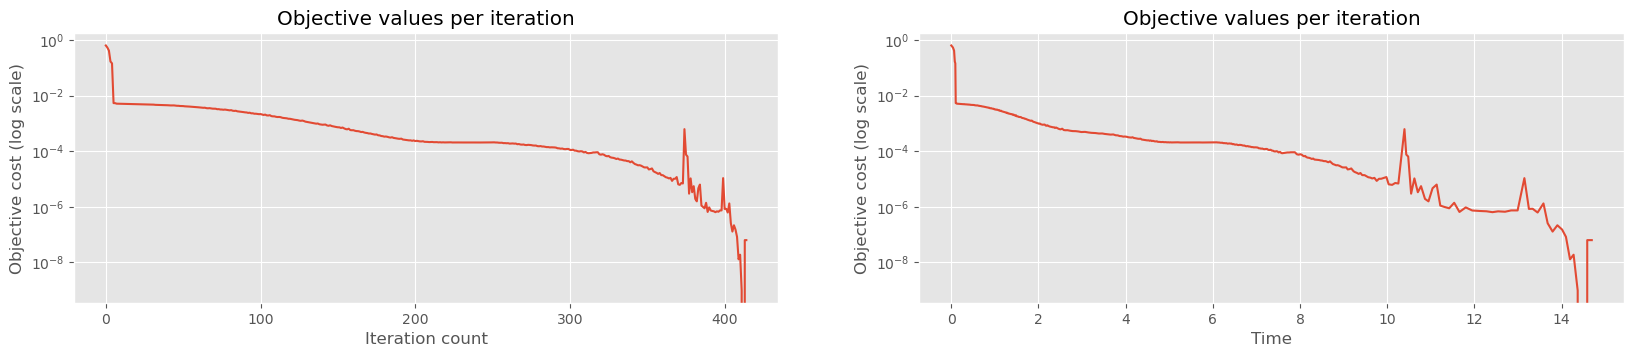

In [44]:
# Visualise evolution of objective values
plt.figure(figsize = (20,3.5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [45]:
obj_eval(α)

(array(0.63726528), array([ 1.51940052, -1.05344279, -0.81916712]))

In [46]:
obj_eval(ᾱ)

(array(0.00018149), array([-0.06972862, -0.00526098, -0.00218258]))

---

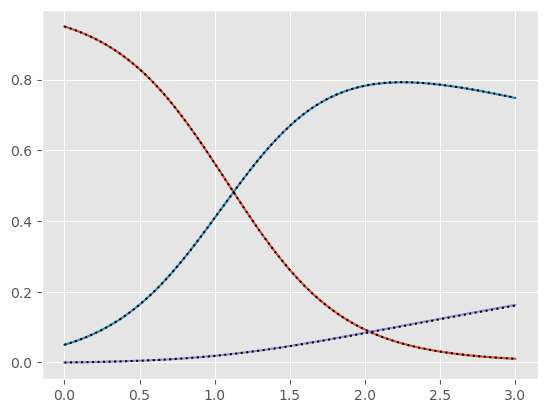

In [47]:
plt.plot(Tₑ, ρ.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.show()

### Varying $\theta$:

In [48]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,1)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00])

In [49]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    #ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, θ, 10000, save_iter = True, critical = 10, ε = 1e-20)
    #ᾱ, ρ, every_critical, every_iter = FISTA(α, 10000, save_iter = True, critical = 100, εₐ = 1e-7, εᵦ = 1e-10,try_TR = False)
    ᾱ, ρ, every_critical, every_iter = nmAPG(α, 10000, save_iter = True, critical = 100, εₐ = 1e-13, εᵦ = 1e-13, print_tests = False);

    # Recover dataframe from results
    every_iter['obj'] = asarray(every_iter['obj'])
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)
    
    
    # Store info from iterate with smallest objective
    ArgMin_nmAPG = df_every.idxmin()['obj']
    Out_θ = df_every.loc[[ArgMin_nmAPG]].rename(index={ArgMin_nmAPG:θ}).copy()
    
    #df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.00  | 1.168e+00   |   1.519e+00  
*    100 |  2.3e-03 |     1.40  | 5.243e-01   |   9.009e-01  
*    200 |  4.1e-04 |     4.59  | 8.319e-02   |   1.430e-01  
*    300 |  2.9e-04 |     7.21  | 3.256e-02   |   5.312e-02  
*    400 |  1.8e-04 |    12.75  | 8.448e-02   |   1.462e-01  
|j-jₖ| < 1e-13

Algorithm stopped after 14.0384 seconds and 414 iterations
[0.00699955 0.10124755 0.04905108]
–––––––––––––––––––– 1e-07 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.00  | 1.168e+00   |   1.519e+00  
*    100 |  2.2e-03 |     1.38  | 3.029e-01   |   5.114e-01  
*    200 |  4.2e-04 |     4.93  | 2.243e-01   |   3.881e-01  
*    300 |  3.7e-04 |     7.83  | 3.943e-0

*   3900 |  5.4e-03 |   100.63  | 5.305e-01   |   9.188e-01  
*   4000 |  5.4e-03 |   103.46  | 3.800e-01   |   6.581e-01  
*   4100 |  5.4e-03 |   106.13  | 6.049e-01   |   1.048e+00  
*   4200 |  5.4e-03 |   108.80  | 2.370e-01   |   4.104e-01  
*   4300 |  5.4e-03 |   111.30  | 1.863e-01   |   3.224e-01  
*   4400 |  5.4e-03 |   113.86  | 3.878e-01   |   6.712e-01  
*   4500 |  5.4e-03 |   116.24  | 9.445e-01   |   1.636e+00  
*   4600 |  5.4e-03 |   118.97  | 4.825e-02   |   8.173e-02  
*   4700 |  5.4e-03 |   121.80  | 3.411e-01   |   5.905e-01  
*   4800 |  5.4e-03 |   124.58  | 1.754e-01   |   3.032e-01  
*   4900 |  5.4e-03 |   127.07  | 8.333e-02   |   1.443e-01  
*   5000 |  5.4e-03 |   129.61  | 2.777e-01   |   4.808e-01  
*   5100 |  5.4e-03 |   132.23  | 8.078e-03   |   1.116e-02  
*   5200 |  5.4e-03 |   134.94  | 7.034e-01   |   1.218e+00  
*   5300 |  5.5e-03 |   137.61  | 1.539e-01   |   2.655e-01  
*   5400 |  5.5e-03 |   140.17  | 5.222e-01   |   9.041e-01  
*   5500

---

In [50]:
#CMap = get_cmap('Wistia')
CMap = colormaps['BuGn']
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

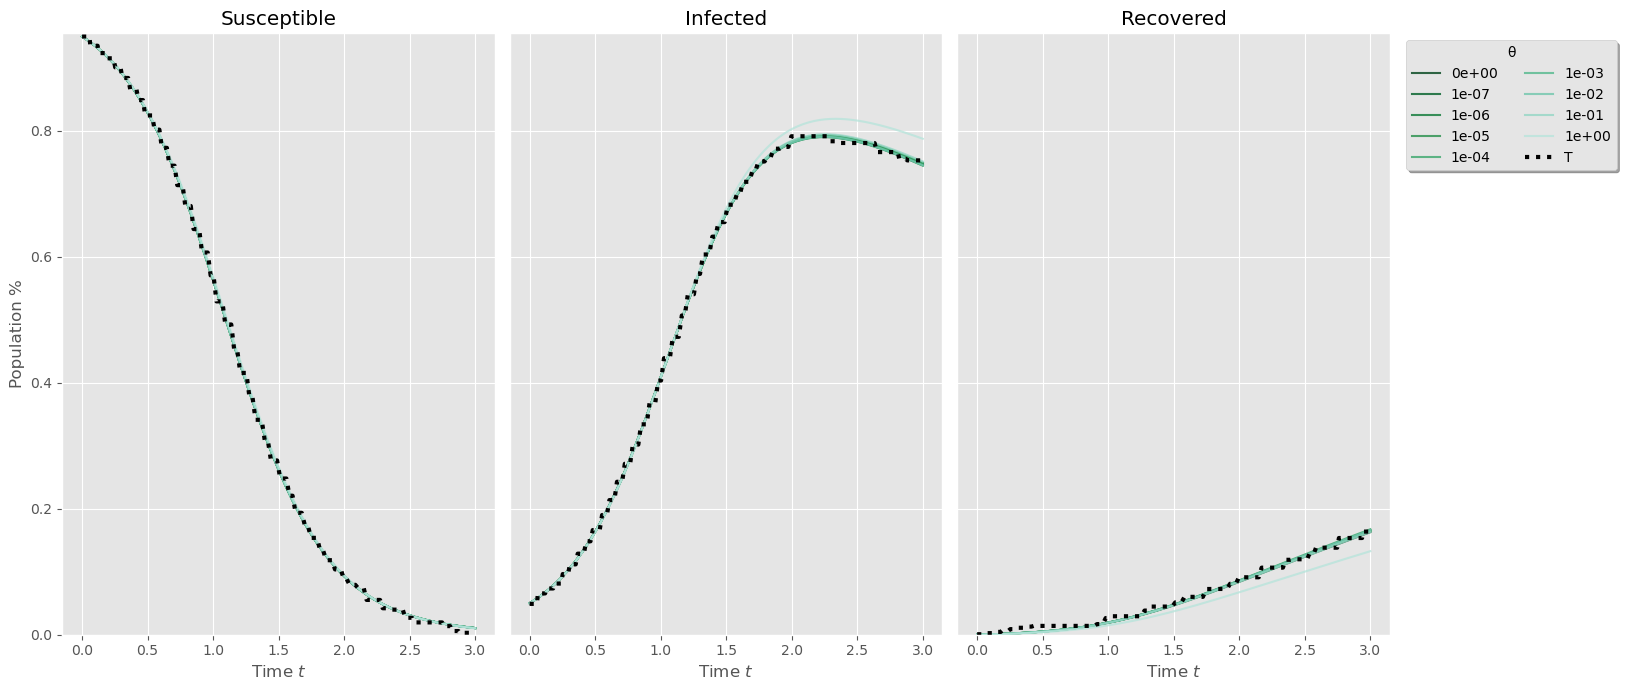

In [51]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – nmAPG.pdf', bbox_inches='tight', pad_inches=0)

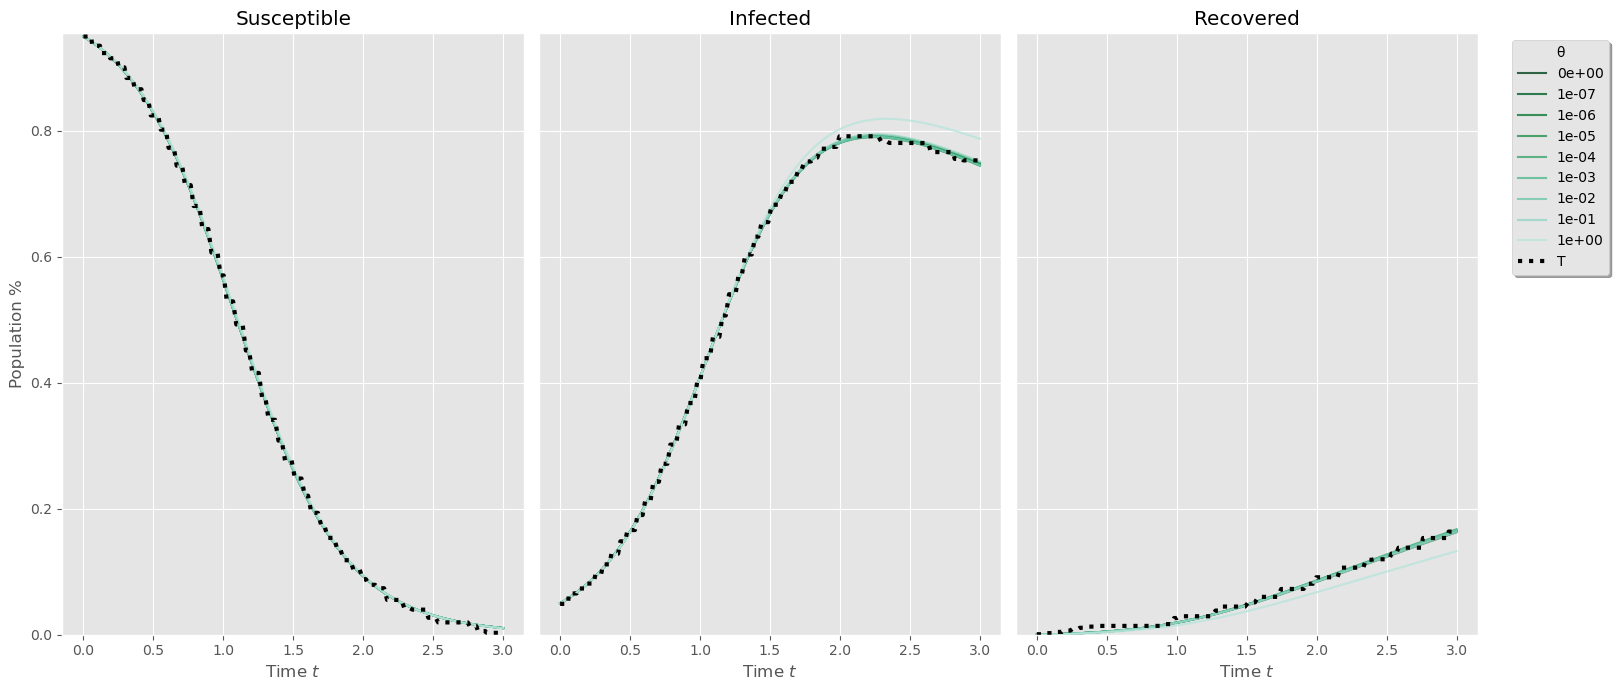

In [67]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", shadow=True, ncol=1, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – nmAPG.pdf', bbox_inches='tight', pad_inches=0)

[]

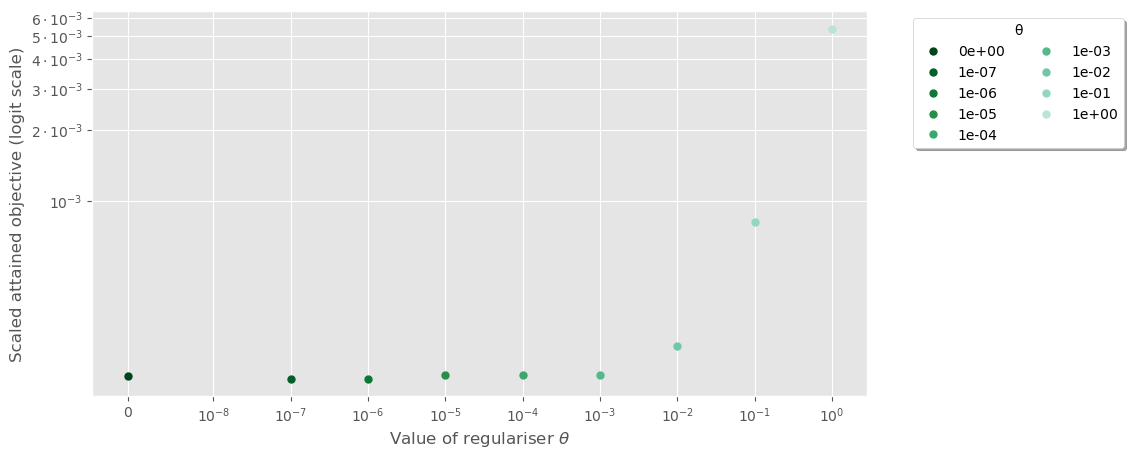

In [52]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh around minimisers:

In [42]:
θ = 0.0

In [43]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,0.01,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [44]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.08483374432970263; (β,γ): 0.0078000000000000005 0.8954666666666666


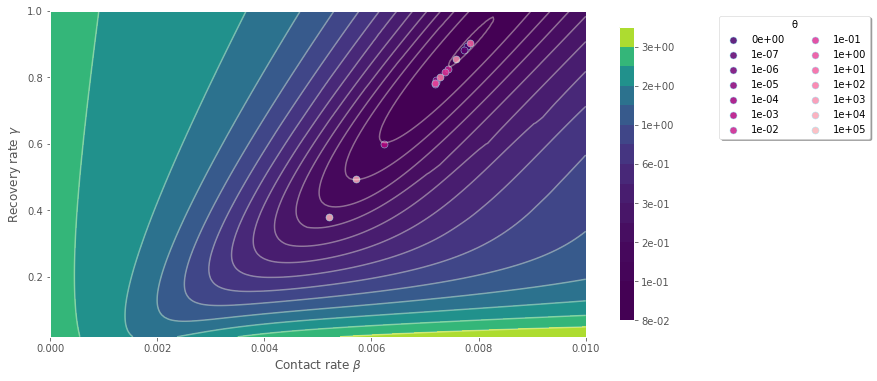

In [45]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min


# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row], edgecolor = "xkcd:robin's egg blue",
         alpha =0.85, marker='.', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)

'''# Optimisation path PGD
ℓ_PGD = 21
h_PGD = 33
plt.plot( clip(β_PGD[ ℓ_PGD:h_PGD],0.02,0.032), clip(γ_PGD[ ℓ_PGD:h_PGD],0.5, 0.7), 
            c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ h_PGD-1:], γ_PGD[ h_PGD-1:], c='gold', alpha=0.7, marker='3', linestyle = '-', 
         markersize=0.1, linewidth=0.05)


# Optimisation path FISTA
ℓ_FISTA = 30
h_FISTA = 40
plt.plot( β_FISTA[ℓ_FISTA:h_FISTA], γ_FISTA[ℓ_FISTA:h_FISTA], c='r', 
             markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa', linewidth=3,
                 alpha=0.75, marker='.', linestyle = '-', markersize='3', label='FISTA')
plt.plot( β_FISTA[ h_FISTA:], γ_FISTA[ h_FISTA:], c='r', markeredgecolor = 'xkcd:rosa', linewidth=2,
             alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
ℓ_LM = 18
plt.plot( clip(β_LM[ℓ_LM:],0.02,0.032), clip(γ_LM[ℓ_LM:],0.5, 0.7), c='xkcd:turquoise blue', 
             markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', linewidth=2.3,
                 alpha=0.9, marker='d', linestyle = '-.', markersize=5, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )'''





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Tests/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

In [445]:
Stats['m'].values

array([0.32166336, 0.31516961, 0.30331642, 0.35765497, 0.29351971,
       0.27291279, 0.30810556, 0.23200179, 0.12776105])

---

In [53]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,412,0.000181,13.829028,0.007000,0.101248,0.049051,-0.069729,-0.005261,-0.002183,0.025724,0.040392,0.069729,0.002183
1.000000e-07,488,0.000176,18.737790,0.007004,0.103370,0.048071,-0.073122,-0.000259,-0.000678,0.024686,0.042219,0.073122,0.000259
1.000000e-06,406,0.000176,13.789583,0.007005,0.102854,0.049462,-0.124581,-0.000010,0.000802,0.041797,0.071928,0.124581,0.000010
1.000000e-05,464,0.000182,17.623400,0.006995,0.102149,0.047266,-0.101747,-0.005335,-0.003572,0.036885,0.058861,0.101747,0.003572
1.000000e-04,526,0.000183,20.825264,0.006992,0.104075,0.045187,-0.009083,-0.002534,-0.004258,0.005292,0.005974,0.009083,0.002534
1.000000e-03,842,0.000182,50.607987,0.007007,0.103080,0.049019,-0.051283,0.000297,0.000306,0.017295,0.029610,0.051283,0.000297
1.000000e-02,745,0.000241,39.111934,0.007005,0.103495,0.048347,-0.095111,0.001781,0.000491,0.032461,0.054923,0.095111,0.000491
1.000000e-01,481,0.000815,17.650394,0.006990,0.101156,0.046518,-0.104735,0.000639,-0.001480,0.035618,0.060476,0.104735,0.000639
1.000000e+00,3196,0.005388,82.320941,0.006889,0.080538,0.042268,1.111673,-0.003803,-0.004499,0.373325,0.641834,1.111673,0.003803


In [54]:
Stats.to_pickle('Outputs/Regularisation – nmAPG - Final.pkl') # To read back use pd.read_pickle(file_name)

In [55]:
print(np.around(Stats,6)[['it','time','β','γ','m','obj','norms-ℓ_2']].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & it & time & β & γ & m & obj & norms-ℓ_2 \\
\midrule
0.000000 & 412 & 13.829028 & 0.007000 & 0.101248 & 0.049051 & 0.000181 & 0.040392 \\
0.000000 & 488 & 18.737790 & 0.007004 & 0.103370 & 0.048071 & 0.000176 & 0.042219 \\
0.000001 & 406 & 13.789583 & 0.007005 & 0.102854 & 0.049462 & 0.000176 & 0.071928 \\
0.000010 & 464 & 17.623400 & 0.006995 & 0.102149 & 0.047266 & 0.000182 & 0.058861 \\
0.000100 & 526 & 20.825264 & 0.006992 & 0.104075 & 0.045187 & 0.000183 & 0.005974 \\
0.001000 & 842 & 50.607987 & 0.007007 & 0.103080 & 0.049019 & 0.000182 & 0.029610 \\
0.010000 & 745 & 39.111934 & 0.007005 & 0.103495 & 0.048347 & 0.000241 & 0.054923 \\
0.100000 & 481 & 17.650394 & 0.006990 & 0.101156 & 0.046518 & 0.000815 & 0.060476 \\
1.000000 & 3196 & 82.320941 & 0.006889 & 0.080538 & 0.042268 & 0.005388 & 0.641834 \\
\bottomrule
\end{tabular}



In [56]:
γₑ/(γₑ+mₑ), mₑ/(γₑ+mₑ)

(0.6666666666666666, 0.3333333333333333)

---

# Others

Check derivative in $m$:

In [41]:
nm = 40
m_axis = linspace(0,1,nm)
f_fix = zeros(nm)
df_fix = zeros(nm)
for (k,m) in enumerate(m_axis):
    fval = obj_eval( asarray([0.5,0.5,m]) )
    f_fix[k] = fval[0].item()
    df_fix[k] = fval[1][2]

In [42]:
np.gradient(f_fix,m_axis)

array([-0.73850861, -0.70743583, -0.64818336, -0.59442718, -0.54561834,
       -0.50126591, -0.4609306 , -0.42421905, -0.39077882, -0.36029391,
       -0.33248078, -0.3070849 , -0.28387757, -0.26265321, -0.24322686,
       -0.225432  , -0.20911864, -0.19415159, -0.18040884, -0.16778028,
       -0.15616645, -0.14547741, -0.13563193, -0.12655636, -0.11818392,
       -0.1104542 , -0.1033123 , -0.09670833, -0.09059798, -0.08493986,
       -0.07969559, -0.07483145, -0.07031544, -0.06612198, -0.06222802,
       -0.05860168, -0.0552216 , -0.05208492, -0.04915222, -0.04772702])

In [449]:
df_fix

array([-0.77104396, -0.70641419, -0.64714585, -0.59321971, -0.54451489,
       -0.50035809, -0.45946273, -0.42357246, -0.38993117, -0.35925007,
       -0.33145565, -0.30623889, -0.28319509, -0.2622956 , -0.24251137,
       -0.22508879, -0.20899608, -0.19370206, -0.18015304, -0.16753271,
       -0.15588934, -0.14501275, -0.1351543 , -0.12645985, -0.11792706,
       -0.11022999, -0.10322236, -0.09671777, -0.09070624, -0.08459601,
       -0.07967306, -0.07490965, -0.07046635, -0.06636451, -0.06203198,
       -0.05857145, -0.05517206, -0.05156727, -0.0484922 , -0.04639627])

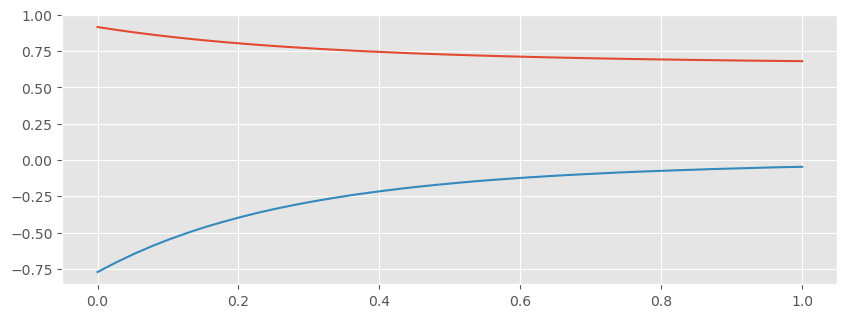

In [448]:
plt.figure(figsize=(10,3.5))
plt.plot(m_axis, f_fix)
plt.plot(m_axis, df_fix)
plt.show()

---